<h1>Regression

In [1]:
# model
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
# optimizer
from torch import optim

In [3]:
# dataset
import torch.utils.data as Data
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt


<h1> 생각할 것 5 가지

1. Dataset (train/validation/test dataset) - input / output
2. Optimizer
3. Loss
4. Model

<h1> 1. Dataset

In [78]:
train_file = pd.read_csv('sample_data/california_housing_train.csv')
test_file = pd.read_csv('sample_data/california_housing_test.csv')

In [79]:
train_file.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0
5,-114.58,33.63,29.0,1387.0,236.0,671.0,239.0,3.3438,74000.0
6,-114.58,33.61,25.0,2907.0,680.0,1841.0,633.0,2.6768,82400.0
7,-114.59,34.83,41.0,812.0,168.0,375.0,158.0,1.7083,48500.0
8,-114.59,33.61,34.0,4789.0,1175.0,3134.0,1056.0,2.1782,58400.0
9,-114.60,34.83,46.0,1497.0,309.0,787.0,271.0,2.1908,48100.0


In [80]:
len(train_file)

17000

In [81]:
X_train = train_file.loc[:,'longitude':'median_income'].values
Y_train = train_file['median_house_value'].values

In [82]:
type(X_train)

numpy.ndarray

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
input_data = scaler.transform(X_train)

In [85]:
input_data[:, 0].shape


(17000,)

In [86]:
input_data[:, 0].mean()

0.47688164987110326

In [90]:
X_train[:, 0]

array([-114.31, -114.47, -114.56, ..., -124.3 , -124.3 , -124.35])

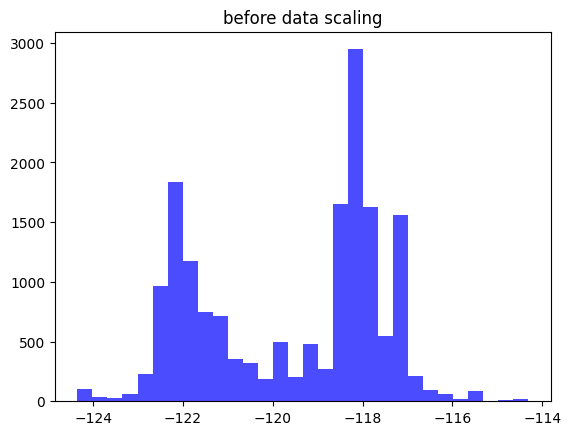

In [91]:
plt.hist(X_train[:, 0], bins=30, color= 'b', alpha = 0.7)
plt.title('before data scaling')
plt.show()

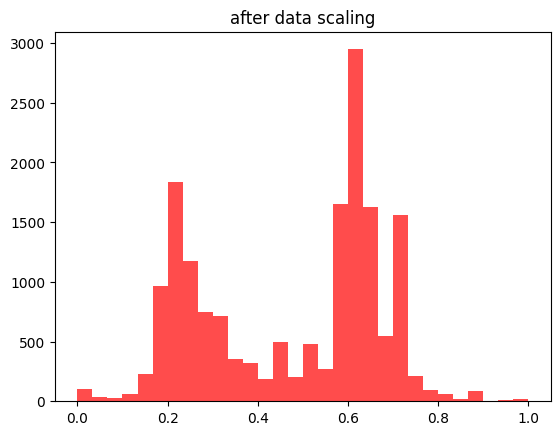

In [92]:
plt.hist(input_data[:, 0], bins=30, color= 'r', alpha = 0.7)
plt.title('after data scaling')
plt.show()

In [93]:
X_test = test_file.loc[:,'longitude':'median_income'].values
Y_test = test_file['median_house_value'].values

In [94]:
targets = scaler.transform(X_test)


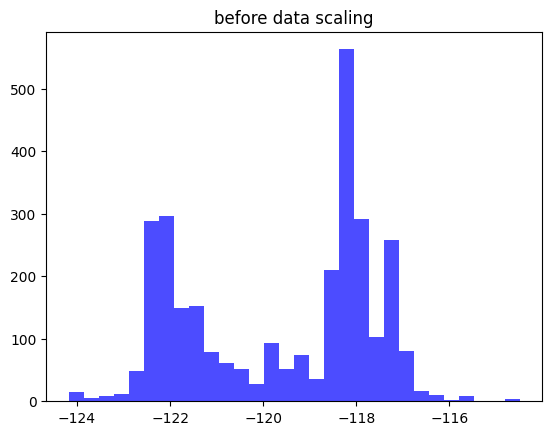

In [96]:
plt.hist(X_test[:, 0], bins=30, color= 'b', alpha = 0.7)
plt.title('before data scaling')
plt.show()

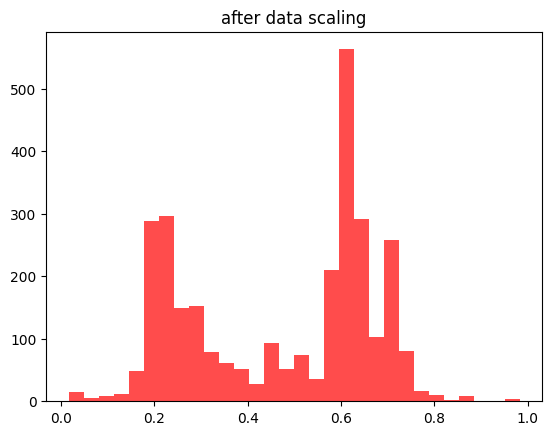

In [97]:
plt.hist(targets[:, 0], bins=30, color= 'r', alpha = 0.7)
plt.title('after data scaling')
plt.show()

In [104]:
x_train, x_val, y_train, y_val = train_test_split(input_data, Y_train, test_size=0.2, random_state = 2003)

In [105]:
x_train.shape , y_train.shape , x_val.shape , y_val.shape

((13600, 8), (13600,), (3400, 8), (3400,))

In [106]:


class HousingDataset(Data.Dataset):
    def __init__(self, X, y):
        # scaler = StandardScaler()
        # scaler = MinMaxScaler()
        # self.targets = scaler.fit_transform(X.astype(np.float32))
        self.targets = X.astype(np.float32)
        self.labels = y.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return self.targets[i, :], self.labels[i]



In [107]:
batch_size = 64

In [108]:

train_set = HousingDataset(x_train, y_train)
val_set = HousingDataset(x_val, y_val)


train_loader = Data.DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size, shuffle=True, drop_last=True)


In [109]:

test_set = HousingDataset(targets, Y_test)
test_loader = Data.DataLoader(test_set, batch_size, shuffle=False, drop_last=True)

<h1> 2. Optimizer , 3. Loss , 4. model

In [110]:

class Model(nn.Module):
    def __init__(self, n_features, hiddenA, hiddenB):
        super(Model, self).__init__()
        self.linearA = nn.Linear(n_features, hiddenA)
        self.linearB = nn.Linear(hiddenA, hiddenB)
        self.linearC = nn.Linear(hiddenB, 1)

    def forward(self, x):
        yA = F.relu(self.linearA(x))
        yB = F.relu(self.linearB(yA))
        return self.linearC(yB)


In [111]:
model = Model(8, 100, 50)

In [112]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [113]:

n_epochs = 2000
all_losses = []
for epoch in tqdm.tqdm(range(n_epochs)):

    losses = []
    total = 0
    for inputs, target in train_loader:
        optimizer.zero_grad()

        y_pred = model(inputs)
        loss = criterion(y_pred, torch.unsqueeze(target,dim=1))

        loss.backward()

        optimizer.step()

        losses.append(loss.item()/len(inputs))
        total += 1

    epoch_loss = sum(losses) / total
    all_losses.append(epoch_loss)

    if epoch % 100 == 0 :
        mess = f"Epoch #{epoch+1}\tLoss: {all_losses[-1]:.3f}"
        tqdm.tqdm.write(mess)


  0%|          | 1/2000 [00:00<19:30,  1.71it/s]

Epoch #1	Loss: 234839562.585


  5%|▌         | 101/2000 [00:49<14:14,  2.22it/s]

Epoch #101	Loss: 50507474.670


 10%|█         | 201/2000 [01:35<15:05,  1.99it/s]

Epoch #201	Loss: 42595082.528


 15%|█▌        | 301/2000 [02:20<15:37,  1.81it/s]

Epoch #301	Loss: 40672111.406


 20%|██        | 401/2000 [03:07<13:11,  2.02it/s]

Epoch #401	Loss: 37493001.245


 25%|██▌       | 501/2000 [03:54<12:51,  1.94it/s]

Epoch #501	Loss: 34874446.368


 30%|███       | 601/2000 [04:42<10:35,  2.20it/s]

Epoch #601	Loss: 33420490.967


 35%|███▌      | 701/2000 [05:31<09:51,  2.19it/s]

Epoch #701	Loss: 32102976.264


 40%|████      | 801/2000 [06:19<09:08,  2.19it/s]

Epoch #801	Loss: 31266509.783


 45%|████▌     | 901/2000 [07:09<08:35,  2.13it/s]

Epoch #901	Loss: 30254130.575


 48%|████▊     | 961/2000 [07:38<08:15,  2.10it/s]


KeyboardInterrupt: ignored

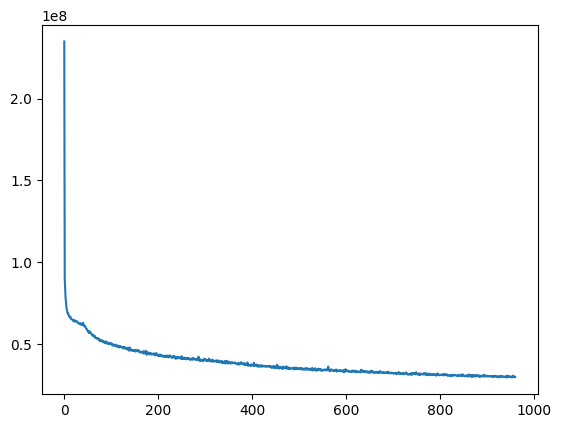

In [114]:

plt.plot(all_losses)

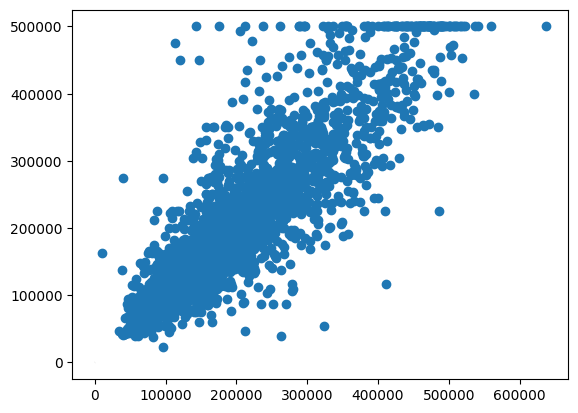

In [115]:

y_pred = []
y_true = []
model.eval()
for inputs, targets in test_loader:
    y_pred.extend(model(inputs).data.numpy())
    y_true.extend(targets.numpy())
plt.scatter(y_pred, y_true)
plt.plot([0, 50], [0, 50], '--k')